**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Original image:


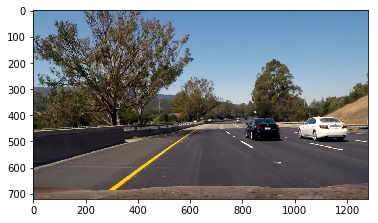

Final image:


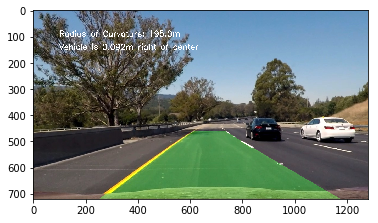

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

%matplotlib inline

global left_fit_global
global right_fit_global

left_fit_global = [] 
right_fit_global = []

# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
def camera_cal(img, corn_num=(9, 6)):
    objpoints = [] # 3D points in real wold space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0, 0, 0), (2, 0, 0) ...., (7, 5, 0)
    objp = np.zeros((corn_num[0]*corn_num[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:corn_num[0], 0:corn_num[1]].T.reshape(-1, 2) # x, y coordinates

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find teh chessboard corders
    ret, corners = cv2.findChessboardCorners(gray, corn_num, None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


# 2. Apply a distortion correction to raw images.
def undistort_image(img, cal_mtx, dist_coef):
    undst = cv2.undistort(img, cal_mtx, dist_coef, None, cal_mtx)
    return undst


# 3. Use color transforms, gradients, etc., to create a thresholded binary image.
def threshold_treatment(img, r_thresh=(180, 255), s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Extract R channel, to get rid of shadows of the tree
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    R_binary = np.zeros_like(R)
    R_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (R_binary == 1)] = 1    
    
    # Adopt the mask to focus on interested areas
    mask = np.zeros_like(combined_binary)
    vertices = np.array([[(100,720),(545,470),(755,470),(1290,720)]],dtype=np.int32)
    cv2.fillPoly(mask,vertices,1)
    masked_image = cv2.bitwise_and(combined_binary,mask)
        
    return masked_image


# 4. Apply a perspective transform to rectify binary image ("birds-eye view").
def warper(img, img_size, inv_warp=False):
    src = np.float32(
        [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 63), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4 - 100), 0],
         [(img_size[0] / 4 - 100), img_size[1]],
         [(img_size[0] * 3 / 4 + 50), img_size[1]],
         [(img_size[0] * 3 / 4 + 50), 0]])
    
    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp an image using the perspective transform M
    if inv_warp == True:
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped


# 5. Detect lane pixels and fit to find the lane boundary.
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = left_fit_global
    right_fit = right_fit_global
    
    ### Set the area of search based on activated x-values ###k
    ### within the +/- margin of polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
#     print('Point number:', len(left_lane_inds))
    
    minpix = 5000
    

    if (len(right_lane_inds) < minpix) or (len(left_lane_inds) < minpix):
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    else:
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Create global variable to store the left_fit and right_fit curves
    global left_fit_global
    global right_fit_global
    # Find lane pixels:
    # If left_fit and right_fit exist, search for lane pixels from start
    # otherwise, searh with the lane curve based on last frame
    if (len(left_fit_global) < 1) or (len(right_fit_global) < 1):
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    else:
        leftx, lefty, rightx, righty = search_around_poly(binary_warped)            

    # Fit a second order polynomial to each using `np.polyfit`
    # and update the polynomial of the global variable
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_global = left_fit
    right_fit_global = right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return ploty, left_fit, right_fit


# 6.Determine the curvature of the lane and vehicle position with respect to center.
# Calculate the distance from the midpoint of the vehicle to the center of the lane
def lane_center(warped_img, ploty, left_fit, right_fit):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    center_lane = (left_fitx + right_fitx)/2
    car_center_dis = (center_lane[-1] - warped_img.shape[1]/2)
    return car_center_dis


def measure_curvature_pixels(warped_img):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = fit_polynomial(warped_img)
    car_lanecenter_distance = lane_center(warped_img, ploty, left_fit, right_fit) * xm_per_pix
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Curvature_meter = Curvature_pixel * Radius_pixel / Radius_meter
    curvature = ((left_curverad + right_curverad) * ym_per_pix / 2)
    
    return curvature, car_lanecenter_distance


# 7. Warp the detected lane boundaries back onto the original image.
def draw_area(undist,binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, inv_warp=True, img_size=(undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
def draw_values(img, curvature, distance_from_center):
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature: %sm" % (round(curvature))
 
    if distance_from_center > 0:
        pos_flag = 'right'
    else:
        pos_flag = 'left'
 
    cv2.putText(img, radius_text, (100, 100), font, 1, (255, 255, 255), 2)
    center_text = "Vehicle is %.3fm %s of center" % (abs(distance_from_center), pos_flag)
    cv2.putText(img, center_text, (100, 150), font, 1, (255, 255, 255), 2)
    return img

# Create the processing pipeline for image treatment
def img_pipeline(img):
    
    # 2. apply distortion
    undist_img = undistort_image(img, cal_mtx, dist_coef)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded 
    binary_img = threshold_treatment(undist_img)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_img = warper(binary_img, inv_warp=False, img_size=(undist_img.shape[1], undist_img.shape[0]))
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    ploty_fit, left_fitx, right_fitx = fit_polynomial(warped_img)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    lane_curvature, car_lane_center_distance = measure_curvature_pixels(warped_img)
    
    # 7. Warp the detected lane boundaries back onto the original image.
    lane_marked_img = draw_area(undist_img, warped_img, left_fitx, right_fitx)
    
    # 8. Output visual display of the lane boundaries and numerical estimation
    output_img = draw_values(lane_marked_img, lane_curvature, car_lane_center_distance)
    
    return output_img

# Read and display the original image
source_img = mpimg.imread('camera_cal/calibration2.jpg')
cal_mtx, dist_coef = camera_cal(source_img)

# Test the pipeline based on a test image
test_image = mpimg.imread('test_images/test6.jpg')
print('Original image:')
plt.imshow(test_image)
plt.show()
output_image = img_pipeline(test_image)
print('Final image:')
plt.imshow(output_image)
plt.show()



In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_video/marked_img.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(35, 45)
white_clip = clip1.fl_image(img_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_video/marked_img.mp4
[MoviePy] Writing video output_video/marked_img.mp4


100%|█████████▉| 1260/1261 [02:01<00:00, 10.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/marked_img.mp4 

CPU times: user 9min 10s, sys: 53 s, total: 10min 3s
Wall time: 2min 2s
